In [1]:
import h5py
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

import warnings
warnings.filterwarnings('ignore', '.*FutureWarning*.')
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

In [2]:
output_path = '../../data/dedalus/spinup'

In [3]:
f = h5py.File(output_path+"/output.h5", 'r')

data = f['tasks']
t = data['b'].dims[0]['sim_time'][:]#/86400.
z = data['b'].dims[1]['z/1.0'][:]
z = data['bz'].dims[1]['z/1.0'][:]

b = data['b'][:,:].swapaxes(0,1)
u = data['u'][:,:].swapaxes(0,1)
v = data['v'][:,:].swapaxes(0,1)

bz = data['bz'][:,:].swapaxes(0,1)
uz = data['uz'][:,:].swapaxes(0,1)
vz = data['vz'][:,:].swapaxes(0,1)

In [12]:
nIter = 40
step0 = 360
nstep = step0

iters = range(step0,nIter*nstep+step0,nstep)
print(list(iters))

[360, 720, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680, 5040, 5400, 5760, 6120, 6480, 6840, 7200, 7560, 7920, 8280, 8640, 9000, 9360, 9720, 10080, 10440, 10800, 11160, 11520, 11880, 12240, 12600, 12960, 13320, 13680, 14040, 14400]


In [13]:
data_dir = "../../MITgcm/experiments/rotated_rest/run/"

ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["standardDiag"])

ds['time'] = ds['time']*30 # convert from iterations to seconds
grid = xgcm.Grid(ds, periodic=['X','Y'])

coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
coords['dV'] = coords['rA']*(coords['drF']*coords['hFacC'])

H = coords['Depth'].max()
ds['Z'].values = ds['Z'].values + H.values
ds['Zl'].values = ds['Zl'].values + H.values

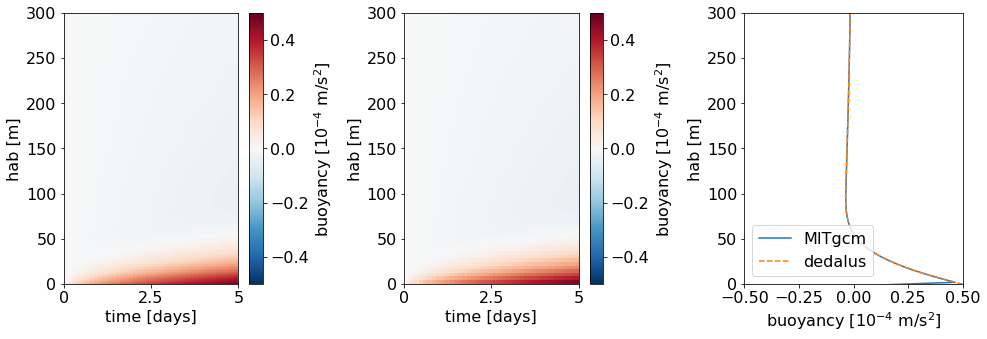

In [18]:
slice_time = nIter*3.*60.*60.

ylim = [0., 300.]
tlim = [0, slice_time]

plt.figure(figsize=(14,9))

plt.subplot(2,3,1)
plt.pcolormesh(t, z, b*1.e4, cmap=div_cmap)
plt.colorbar(label='buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.clim([-0.5,0.5])
plt.xlabel('time [days]')
plt.xticks([0, 2.5*86400., 5.*86400.], [0, 2.5, 5])

plt.subplot(2,3,2)
g = 9.81; tAlpha = 2.e-4
ds['b'] = ds['THETA']*(g*tAlpha)
q = (ds['b'].mean(dim=['XC','YC'])*1.e4).plot(y='Z')
q.set_clim([-0.5,0.5])
q.colorbar.set_label('buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.xlabel('time [days]')
plt.xticks([0, 2.5*86400., 5.*86400.], [0, 2.5, 5])

plt.subplot(2,3,3)

plt.plot(
    ds['b'].isel(time=np.argmin(np.abs(ds['time']-slice_time))).mean(dim=['XC','YC']).values*1.e4,
    ds['Z'],
    label='MITgcm')

plt.plot(b[:,[np.argmin(np.abs(t-slice_time))]]*1.e4, z, "--", label='dedalus')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim([-0.5,0.5])
plt.xlabel(r'buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.legend()

plt.tight_layout()